**Comparaision VITS/Langevin**

Data : 

Return 
- X, of dimention, n_samples, n_features
- Y of dimention n_targets  * n_samples
- theta star is true_weights

A faire varier pour notre problème : 

- 1) Imporn_features with n_informative features pour l'exploration à montrer
- 2) effective_rank : (int)  The approximate number of singular vectors required to explain most of the input data by linear combinations. 


In [639]:
from sklearn.datasets._samples_generator import check_array, check_random_state, make_low_rank_matrix
import numpy as np
from sklearn.utils import shuffle as util_shuffle
import matplotlib.pyplot as plt

from collections import deque

In [1009]:
def regression_model(
    n_samples=100,
    n_features=100,
    n_informative=10,
    n_targets=1,
    bias=0.0,
    effective_rank=None,
    tail_strength=0.9,
    noise=1,
    shuffle=True,
    coef=True,
    random_state=None,
    lbd=1
):
    
    n_informative = min(n_features, n_informative)
    generator_ground = check_random_state(20)
    generator=check_random_state(random_state)
    
    if effective_rank is None:
        # Randomly generate a well conditioned input set
        X = generator.standard_normal(size=(n_samples, n_features))
    else:
        # Randomly generate a low rank, fat tail input set
        X = make_low_rank_matrix(
            n_samples=n_samples,
            n_features=n_features,
            effective_rank=effective_rank,
            tail_strength=tail_strength,
            random_state=generator,
        )
        X/=np.linalg.norm(X,2,axis=1,keepdims=True)

    # Autre méthode pour matrice mal conditionnnée
    #n_samples=100
    #gauss_matrix= np.random.normal(size=(20,n_features))
   # X=gauss_matrix[np.random.randint(gauss_matrix.shape[0], size=n_samples), : ]

    #print("cond",np.linalg.cond(X.T@X))
                    
    ground_truth = np.zeros((n_features, n_targets))
    ground_truth[:n_informative, :] = 10* generator_ground.normal(
        size=(n_informative, n_targets)
    )
    # normalised
    ground_truth/=np.linalg.norm(ground_truth,2)

    y = np.dot(X, ground_truth) + bias

    # Add noise
    if noise > 0.0:
        y += generator.normal(scale=noise, size=y.shape)

    # Randomly permute samples and features
    if shuffle:
        X, y = util_shuffle(X, y, random_state=20)

        indices = np.arange(n_features)
        generator_ground.shuffle(indices)
        X[:, :] = X[:, indices]
        ground_truth = ground_truth[indices]

    y = np.squeeze(y)

    if coef:
        return X, y, np.squeeze(ground_truth) , np.linalg.cond( lbd* np.eye(n_features) + X.T@X)
    else:
        return X, y , np.linalg.cond( lbd* np.eye(n_features) + X.T@X)

In [1005]:
x, y, true_weights ,_= regression_model(n_samples=10000, n_features=50, n_informative=50, n_targets=1, 
 bias=0.0, effective_rank=None, 
 tail_strength=0.5, noise=0.0, 
 shuffle=True, coef=True, random_state=None)
print( x)

[[ 0.11245996 -0.11872164  0.64857369 ... -1.1999966   0.66383183
   0.89689624]
 [-1.74324102  0.60559428  0.50887434 ...  0.59673519  0.50497758
  -0.05532543]
 [-0.28713033 -0.42175444  1.10323653 ... -1.37966938  0.5785633
   0.95384869]
 ...
 [-0.58978335  0.00960997  1.25726639 ...  0.13605808 -0.54954424
   0.45928532]
 [ 0.71009402  0.93649514  1.40370055 ...  0.59239348 -0.65908166
   1.45079301]
 [-0.88608848  0.28437769 -0.92058949 ... -0.60196953  0.03537242
   0.76163015]]


**Use ill conditionned matrix**

In [1032]:
class LMC():
    
    def __init__(self, true_param, dimention,max_iter,lbd,eta,h,K=50):
        
        self.dimention=dimention
        self.lbd=lbd
        self.eta=eta
        self.true_param=true_param
        self.V=self.lbd*np.eye(self.dimention) + x.T@x
        self.b=y@x
        self.max_iter=max_iter
        self.h=h
        
        
    def gradient(self,theta,y,x):
        
        return (self.V@theta)-self.b
        
    def update_mean(self, mean, gradient, h,T):
        #print("grad",np.linalg.norm(h * gradient),  'bruit', np.linalg.norm(np.sqrt( 2 * h /self.eta) *np.random.normal( size=(self.dimention, 1)).squeeze() ) )
        return mean - h * gradient + np.sqrt( 2 * h /self.eta) *np.random.normal( size=(self.dimention, 1)).squeeze() 
        
    def run(self,x,y):
        
        # initilialisation mean
        theta=np.zeros(self.dimention)
        dists_mean=[]
        dists_theta=[]
        cov_norms=[]
        thetas=deque([],maxlen=10)
           
        for t in range(self.max_iter):
            
            grad=self.gradient(theta,y,x)
    
            theta=self.update_mean(theta,grad,self.h,self.eta)
            
            thetas.append(theta)
            
            mean=np.mean(thetas,axis=0)
            #cov=np.cov(thetas[-10:])
                #print(mean)
            dists_mean.append(np.linalg.norm(self.true_param-mean,ord=2))
            dists_theta.append(np.linalg.norm(self.true_param-theta,ord=2))
            #cov_norms.append(np.linalg.norm(cov))
        #print( self.true_param-mean)
        return mean ,dists_mean,dists_theta   #,  cov_norms
        


In [1057]:
class VI_gaussian():

    def __init__(self,true_param,dimention,max_iter,lbd,eta,h,approx=True,K=10):
        
        self.dimention=dimention
        self.lbd=lbd
        self.eta=eta
        self.approx=approx
        self.true_param=true_param
        self.K=K
        self.V=self.lbd*np.eye(self.dimention) + x.T@x
        self.b=b=y@x
        self.hessian=self.eta*(self.lbd*np.eye(self.dimention) + x.T@x)
        self.max_iter=max_iter
        self.h=h
        
    def gradient(self,theta,y,x):
        return (self.eta*(self.V@theta-self.b))
        
    
    
    def update_mean(self, mean, gradient, h):
        return mean - h * gradient
    
    def update_cov(self, cov_semi, cov_semi_inv, hessian, h):
        cov_semi = (np.eye(self.dimention) - h * hessian) @ cov_semi + h * cov_semi_inv.T
        
        if self.approx:
            cov_semi_inv = cov_semi_inv @ (np.eye(self.dimention) - h * (np.matmul(cov_semi_inv.T , cov_semi_inv) - hessian))
        else:
            cov_semi_inv = np.linalg.pinv(cov_semi)
        return cov_semi, cov_semi_inv
    
    def sample(self, mean, cov_semi):
        
        
        eps = np.random.normal( size=(self.dimention, 1))
        theta = mean.T + (cov_semi @ eps).squeeze()
        
        #print("theta",theta.shape)
        return  theta.squeeze()
    
    def compute_cond_number(self, mean, cov_semi,label,features):
        features, labels, mean, cov_semi, _ = utils_vector
        theta = self.sample( mean, cov_semi)
        regularization_hessian = 2 * self.lbd * jnp.eye(self.dimension)
        data_hessian = np.sum(jax.vmap(self.hessian_function, in_axes=(None, 0, 0))(theta, features, labels), axis=0)
        hessian = self.eta *  (regularization_hessian + data_hessian)
        return np.linalg.cond(hessian)
    
    def run(self,x,y):
        
        mean=np.zeros(self.dimention)
        cov=(1/5)*np.sqrt(1/(self.eta*self.lbd))*np.eye(self.dimention)
        dists=[]
        cov_inv=5*np.sqrt((self.eta*self.lbd))*np.eye(self.dimention)
        thetas=[]
        for t in range(self.max_iter):
            
            # sample
            #for k in range(self.K):
            theta=self.sample(mean,cov)
            # compute grad and hessian
            grad=self.gradient(theta,y,x)
            
            # Update mean and cov
            mean=self.update_mean(mean,grad,self.h)
            cov,cov_inv=self.update_cov(cov,cov_inv,self.hessian,self.h)
            
            # compute the distance
            dists.append(np.linalg.norm(self.true_param-mean,ord=2))
            
        def run2(self,x,y):
        
        mean=np.zeros(self.dimention)
        cov=np.sqrt(1/(self.eta*self.lbd))*np.eye(self.dimention)
        dists=[]
        cov_inv=np.sqrt((self.eta*self.lbd))*np.eye(self.dimention)
        thetas=[]
        while eps>10 in range(self.max_iter):
            
            # sample
            #for k in range(self.K):
            theta=self.sample(mean,cov)
            # compute grad and hessian
            grad=self.gradient(theta,y,x)
            
            # Update mean and cov
            mean=self.update_mean(mean,grad,self.h)
            cov,cov_inv=self.update_cov(cov,cov_inv,self.hessian,self.h)
            
            # compute the distance
            dists.append(np.linalg.norm(self.true_param-mean,ord=2))
            
        return mean, cov ,dists
    

IndentationError: expected an indented block (962269529.py, line 75)

**Algorrithms** : Langevin : VITS

[0.1752796028119212]


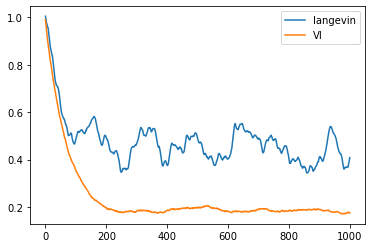

In [1062]:
x, y, true_weights ,_= regression_model(n_samples=2000, n_features=20, n_informative=20, n_targets=1, 
 bias=0.0, effective_rank=20, 
 tail_strength=0.5, noise=0.5, 
 shuffle=True, coef=True, random_state=345)


max_iter=1000
lbd=1
eta=1
h=1/10000
langevin=LMC(true_weights,true_weights.shape[0],max_iter,lbd,eta,h)
_,dist_mean,dist_theta=langevin.run(x,y)



VI=VI_gaussian(true_weights,true_weights.shape[0],max_iter,lbd,eta,h)
_,_,distVI=VI.run(x,y)
plt.plot(dist_mean,label="langevin")
plt.plot(distVI,label="VI")
print(distVI[-1:])
plt.legend()
plt.show()

In [715]:
x, y, true_weights = regression_model(n_samples=2000, n_features=50, n_informative=50, n_targets=1, 
 bias=0.0, effective_rank=100, 
 tail_strength=0.5, noise=0.0, 
 shuffle=True, coef=True, random_state=None)

In [606]:
x, y, true_weights = regression_model(n_samples=10000, n_features=50, n_informative=50, n_targets=1, 
 bias=0.0, effective_rank=None, 
 tail_strength=0.5, noise=0.0, 
 shuffle=True, coef=True, random_state=None)

cond 1.3003925894169746


In [625]:
x, y, true_weights = regression_model(n_samples=2000, n_features=50, n_informative=50, n_targets=1, 
 bias=0.0, effective_rank=20, 
 tail_strength=0.5, noise=0.0, 
 shuffle=True, coef=True, random_state=None)

cond 6.488207646251193


[293.750261250255]
[339.9563821896573]
[303.3489578113705]
[313.30510548521056]
[287.67773329414393]
[262.18606001988144]
[303.73843217390487]
[295.1051691617341]
[317.84341652650596]
[291.42214972018644]


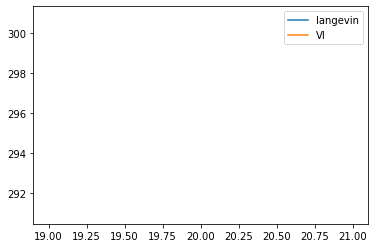

In [730]:
def plot_func():
    dists_langevin=[]
    dists_VI=[]
    dist_seed_langevin=[]
    dist_seed_VI=[]
    
    ranks=[100,50 ,40,30,20,18,15,12,10,8,6]
    ranks=[20]
    seeds=np.arange(10)
    
    
    
    max_iter=3000
    lbd=0.005
    eta=12
    h=1/500
    
    for seed in seeds:
        np.random.seed(seed=seed+1000)
        dists_langevin=[]
        dists_VI=[]
    
        for rank in ranks:
            
            
            x, y, true_weights = regression_model(n_samples=2000, n_features=50, n_informative=50, n_targets=1, 
                 bias=0.0, effective_rank=20, 
                 tail_strength=0.5, noise=0.5, 
                 shuffle=True, coef=True, random_state=seed)

            
            langevin=LMC(true_weights,true_weights.shape[0],max_iter,lbd,eta,h)
            VI=VI_gaussian(true_weights,true_weights.shape[0],max_iter,lbd,eta,h)

            _, dist_mean ,_= langevin.run(x,y)
            _,_,distVI= VI.run(x,y)

            print(distVI[-1:])
            dists_langevin.append(dist_mean[-1:])
            dists_VI.append(distVI[-1:])
                
        dist_seed_langevin.append(dists_langevin)
        dist_seed_VI.append(dists_VI)
        
        final_langevin=np.mean(dist_seed_langevin,axis=0)
        final_VI=np.mean(dist_seed_VI,axis=0)

        
    plt.plot(ranks,final_langevin,label="langevin")
    plt.plot(ranks,final_VI,label="VI")
    plt.legend()
    plt.show()
    
plot_func()
        


        

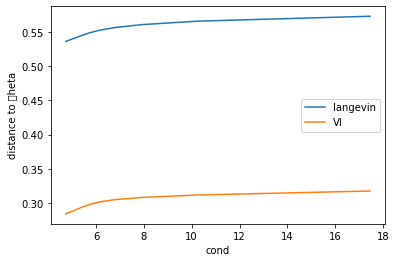

In [1061]:
dists_langevin=[]
dists_VI=[]
dist_seed_langevin=[]
dist_seed_VI=[]
    
#ranks=[100,50 ,40,30,20,18,15,12,10,9,8,7,6,5,4,3]
ranks=[10,9,8,7,6,5,4,3,2]
#ranks=[20]
seeds=np.arange(10)+1
    
    
max_iter=500
lbd=0.005
eta=12
h=1/500
    
    
max_iter=200
lbd=1
eta=1
h=1/10000    

conds=[]   
for rank in ranks:
    
    for seed in seeds:
        np.random.seed(seed=seed+1000)
        final_langevin=[]
        final_VI=[]
        
            
        
        x, y, true_weights,cond = regression_model(n_samples=2000, n_features=20, n_informative=20, n_targets=1, 
                 bias=0.0, effective_rank=rank, 
                 tail_strength=0.5, noise=0.5, lbd=lbd,
                 shuffle=True, coef=True, random_state=seed)

            
        langevin=LMC(true_weights,true_weights.shape[0],max_iter,lbd,eta,h)
        VI=VI_gaussian(true_weights,true_weights.shape[0],max_iter,lbd,eta,h)

        _, dist_mean ,_= langevin.run(x,y)
        _,_,distVI= VI.run(x,y)

        
        dists_langevin.append(dist_mean[-1:])
        dists_VI.append(distVI[-1:])
      
    conds.append(cond)
    final_langevin=np.mean(dists_langevin,axis=0)
    final_VI=np.mean(dists_VI,axis=0)
        
                
    dist_seed_langevin.append(final_langevin)
    dist_seed_VI.append(final_VI)
        


        
plt.plot(conds,dist_seed_langevin,label="langevin")
plt.plot(conds,dist_seed_VI,label="VI")
plt.xlabel("cond")
plt.ylabel("distance to \theta")
plt.legend()
plt.show()
    